## HW2. Part 1. Flow models.

In [1]:
import numpy as np
def sample_data():
    count = 100000
    rand = np.random.RandomState(0)
    a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
    -np.sin(np.linspace(0, np.pi, count // 3))]

    c += rand.randn(*c.shape) * 0.2
    data_x = np.concatenate([a, b, c], axis=0)
    data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
    perm = rand.permutation(len(data_x))
    return data_x[perm], data_y[perm]

In [4]:
from sklearn.model_selection import train_test_split

X, y = sample_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125)

In [5]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(69999, 2) (20000, 2) (69999,) (20000,)
(10000, 2) (10000,)


### An autoregressive flow built out of univariate mixture CDFs.

In [189]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# I wanted to make it universal, but did not manage what to do with different dimensions :(
class CDFParametresFirst(nn.Module):
    def __init__(self, k):
        super(CDFParametresFirst, self).__init__()
        self.pi = nn.Parameter(torch.randn(k, requires_grad=True))
        self.mu = nn.Parameter(torch.randn(k, requires_grad=True))
        self.sigma = nn.Parameter(torch.randn(k, requires_grad=True))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        pi = self.softmax(self.pi)
        mu = self.mu
        # That is because I need sigma^2 > 0 strictly...
        sigma = F.relu(self.sigma) + 0.1
        
        return pi, mu, sigma

class CDFParametresSecond(nn.Module):
    def __init__(self, k, hidden_size):
        super(CDFParametresSecond, self).__init__()

        self.pi = nn.Sequential(nn.Linear(1, hidden_size),
                                nn.ReLU(),
                                nn.Linear(hidden_size, k),
                                nn.Softmax(dim=1))
        self.mu = nn.Sequential(nn.Linear(1, hidden_size),
                                nn.ReLU(),
                                nn.Linear(hidden_size, k))
        self.sigma = nn.Sequential(nn.Linear(1, hidden_size),
                                   nn.ReLU(),
                                   nn.Linear(hidden_size, k))

    def forward(self, x):
        pi = self.pi(x)
        mu = self.mu(x)
        sigma = F.relu(self.sigma(x)) + 0.1
        
        return pi, mu, sigma

In [190]:
from torch.distributions import Normal, Uniform


class AutoregressiveFlow(nn.Module):
    def __init__(self, k, hidden_size):
        super(AutoregressiveFlow, self).__init__()
        self.k = k
        self.params1 = CDFParametresFirst(k)
        self.params2 = CDFParametresSecond(k, hidden_size)

    def forward(self, x):
        x1, x2 = x[:, 0], x[:, 1]

        pi1, mu1, sigma1 = self.params1(x1.view(-1, 1))
        pi2, mu2, sigma2 = self.params2(x1.view(-1, 1))

        p1 = torch.zeros(x.shape[0])
        p2 = torch.zeros(x.shape[0])
        
        
        for i in range(self.k):
            p1 += pi1[i] * Normal(mu1[i], sigma1[i]).log_prob(x1).exp()
            p2 += pi2[:, i] * Normal(mu2[:, i], sigma2[:, i]).log_prob(x2).exp()

        return p1 * p2

    def latent(self, x):
        x1, x2 = x[:, 0], x[:, 1]

        pi1, mu1, sigma1 = self.params1(x1.view(-1, 1))
        pi2, mu2, sigma2 = self.params2(x1.view(-1, 1))

        z1 = torch.zeros(x.shape[0])
        z2 = torch.zeros(x.shape[0])
            
        for i in range(self.k):
            z1 += pi1[i] * Normal(mu1[i], sigma1[i]).cdf(x1)
            z2 += pi2[:, i] * Normal(mu2[:, i], sigma2[:, i]).cdf(x2)

        return z1, z2

    def inverse(self, z):
        z1, z2 = z[:, 0], z[:, 1]

        pi1, mu1, sigma1 = self.params1(z1.view(-1, 1))
        x1 = torch.zeros(z.shape[0])
        for i in range(z.shape[0]):
            j = np.random.choice(self.k, p=pi1.detach().numpy())
            x1[i] = Normal(mu1[j], sigma1[j]).icdf(z1[i])

        pi2, mu2, sigma2 = self.params2(x1.view(-1, 1))
        x2 = torch.zeros(z.shape[0])
        for i in range(z.shape[0]):
            j = np.random.choice(self.k, p=pi2[i].detach().numpy())
            x2[i] = Normal(mu2[i, j], sigma2[i, j]).icdf(z2[i])

        return x1, x2


In [191]:
def NLLLoss(y):
    return -torch.mean(torch.log(y)) / 2

In [207]:
def fit(model, train, val, test, optimizer, loss_function, epoch_cnt, batch_size):
    train_loader = torch.utils.data.DataLoader(torch.from_numpy(train), batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(torch.from_numpy(val), batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(torch.from_numpy(test), batch_size=batch_size)
    train_losses = {}
    val_losses = {}
    global_step = 0
    
    for epoch in range(epoch_cnt):
        for idx, train_batch in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(train_batch.float())
            loss = loss_function(output)
            loss.backward()

            optimizer.step()

            train_losses[global_step] = loss.item()
            global_step += 1

            print('\rINFO: [Epoch %d/%d][idx %d/%d][Global Step: %d] Loss: %s'\
                % (epoch, epoch_cnt, idx, len(train_loader), global_step, loss.item()), end="")

        model.eval()
        loss_values = []
        for idx, val_batch in enumerate(val_loader):
            output = model(val_batch.float())
            val_loss = loss_function(output)
            loss_values.append(val_loss.item())
        val_losses[global_step] = np.mean(np.array(loss_values))
        model.train()
    model.eval()        
    loss_values = []
    for batch_data in test_loader:
        output = model(batch_data.float())
        loss = loss_function(output)
        loss_values.append(loss.item())

    print("\nTest set loss: {:.4f}".format(np.mean(np.array(loss_values))))
    
    return train_losses, val_losses

In [208]:
model = AutoregressiveFlow(8, 200)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [209]:
train_loss_values, val_loss_values =\
    fit(model, X_train, X_val, X_test, optimizer, NLLLoss, 10, 512)

INFO: [Epoch 9/10][idx 136/137][Global Step: 1370] Loss: 0.7092533111572266
Test set loss: 0.7072


In [210]:
import matplotlib.pyplot as plt

def plot_val_train(val_losses, train_losses):
    val_x_vals = val_losses.keys()
    val_y_vals = val_losses.values()

    # Plot the graphs
    plt.xlabel('Num Steps')
    plt.ylabel('Negative Log Likelihood')
    train_x_vals = sorted(train_losses.keys())
    train_y_vals = [train_losses[k] for k in train_x_vals]
    val_x_vals = sorted(val_losses.keys())
    val_y_vals = [val_losses[k] for k in val_x_vals]

    plt.plot(train_x_vals, train_y_vals, label='train')
    plt.plot(val_x_vals, val_y_vals, label='val')

    plt.legend(loc='best')
    plt.show()

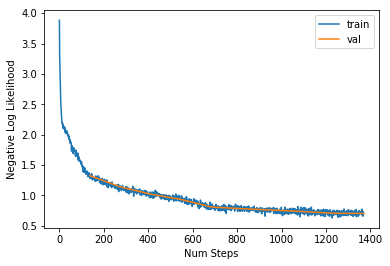

In [211]:
plot_val_train(val_loss_values, train_loss_values)

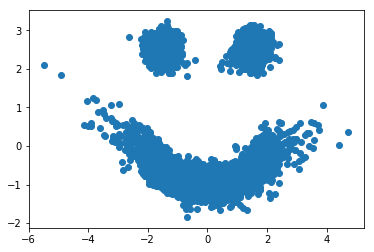

In [212]:
low = torch.tensor([0.0])
high = torch.tensor([1.0])
z = Uniform(low, high).rsample((10000, 2))
x1, x2 = model.inverse(z)
x1 = x1.detach().numpy()
x2 = x2.detach().numpy()
plt.figure()
plt.scatter(x1, x2)

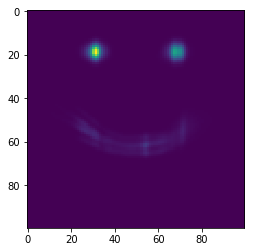

In [213]:
d = np.linspace(-4, 4, 100)
samples = np.array(np.meshgrid(d, d)).T.reshape([-1, 2])
samples = torch.from_numpy(samples).float()
pdf = model(samples).detach().numpy().reshape(100, 100)
plt.imshow(np.rot90(pdf, 1))


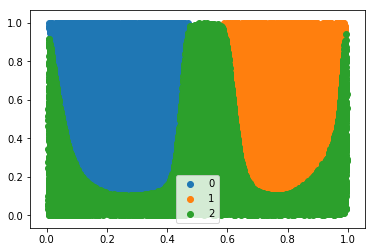

In [214]:
x = torch.from_numpy(X).float()
z1, z2 = model.latent(x)
z1 = z1.detach().numpy()
z2 = z2.detach().numpy()
plt.figure()
plt.scatter(z1[y == 0], z2[y == 0], label='0')
plt.scatter(z1[y == 1], z2[y == 1], label='1')
plt.scatter(z1[y == 2], z2[y == 2], label='2')
plt.legend()

### A realNVP-like model

So, here will be several flows with coupling between them...